<a href="https://colab.research.google.com/github/ol3gka/AI_Masrters_NLA_project_1_Matrix_Masters/blob/main/Maxvol_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import itertools
import time
from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular, get_lapack_funcs, get_blas_funcs

Генератор случайных матриц с фиксированными сингулярными числами для тестов

In [4]:
n, m = map(int, input('Введите размеры матрицы: ').split())
k = int(input('Введите размер крестовой аппроксимации: '))

print('Введите сингулярные числа матрицы: ')
sigma = list(map(float, input().split()))
sigma.sort(reverse=True)
if n<=m:
    S = np.hstack((np.diag(sigma), np.zeros((n,m-n))))
else:
    S = np.vstack((np.diag(sigma), np.zeros((n-m,m))))

B = np.random.randint(100, size=(n,n))
C = np.random.randint(100, size=(m,m))
Q_1 = np.linalg.qr(B, mode='reduced')[0]
Q_2 = np.linalg.qr(C, mode='reduced')[0].transpose()
A = Q_1 @ S @ Q_2
A

Введите размеры матрицы: 12 10
Введите размер крестовой аппроксимации: 4
Введите сингулярные числа матрицы: 
10 9 8 7 7 6 5 3 2 1


array([[ 0.53768524,  1.42664833,  1.40626734, -1.02016401, -2.50355383,
         2.11821513, -2.56954821, -2.67180834,  0.99344782,  0.90379227],
       [-2.24508598,  0.45610144,  1.98799817, -2.04987892, -0.23107959,
        -0.21055398, -1.34838233, -2.70624325, -1.31434308,  1.95511493],
       [ 2.04699928,  1.59026238,  1.10659153,  0.9409079 ,  2.42496483,
         3.87089843,  3.4505862 ,  2.14384447,  3.16239332,  1.18087741],
       [-3.82665082, -1.57932166, -0.58268997,  1.18725815, -1.32511676,
         1.93238879,  1.14128383, -1.44791871,  0.20886544,  0.28511509],
       [-0.04199094,  0.49571828,  2.95057363,  2.8439078 ,  2.4327998 ,
         0.4287534 , -0.03606636, -2.23695525, -0.98724181,  2.13270327],
       [ 1.2908778 ,  2.00583212,  2.08489742, -2.33305648, -2.0834607 ,
         1.04407102, -0.99482158, -2.66874542,  2.26136966,  0.8993814 ],
       [ 1.10831064,  1.13909116, -0.32567238,  1.1183815 ,  1.31304728,
         0.31094592, -0.38401331, -1.23158048

# Adaptive Cross Approximation
Автор: Матевосова Анастасия

**Adaptive Cross Approximation with full pivoting**

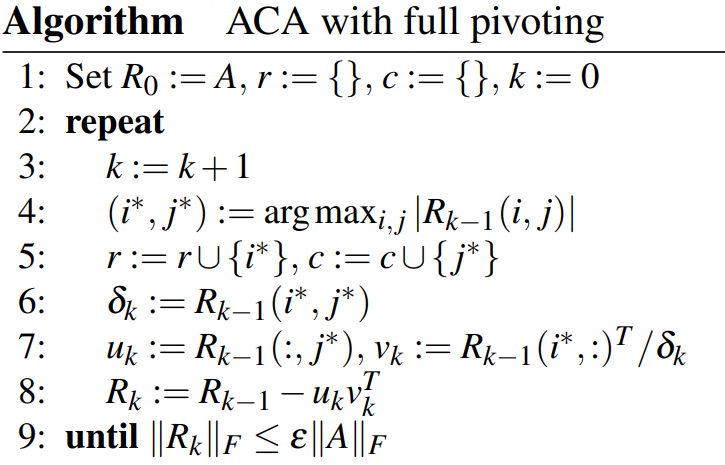

In [ ]:
def  ACA_full_pivoting(A: np.ndarray, epsilon: float):
    '''
    Функция находит adaptive cross-approximation with full pivoting (ACA) матрицы A

    :param A: np.ndarray размера n x m (исходная матрица)
    :epsilon: float требуемая точность построенной малоранговой аппроксимации

    :return U, V: np.ndarray размеров n x r и r x m, произведение которых аппроксимирует матрицу A
               r: int число итераций = число столбцов в матрице U = число строк в матрице V
    '''
    #Инициализация
    I_b = set()
    J_b = set()
    n,m=A.shape[0], A.shape[1]
    R=A.copy()
    r=0
    U=np.zeros((n,0))
    V=np.zeros((0,m))
    while True:
        r=r+1
        #Нахождение индексов максимального элемента в матрице
        i_m,j_m=np.unravel_index(np.argmax(R, axis=None), R.shape)
        I_b.add(i_m)
        J_b.add(j_m)
        d = R[i_m, j_m]
        u = R[:, j_m]
        v = R[i_m, :].T/d
        U=np.column_stack((U,u))
        V=np.row_stack((V,v))
        R = R - np.outer(u,v)
        if np.linalg.norm(R) <= epsilon * np.linalg.norm(A):
            break
    return U,V,r

In [ ]:
A=np.random.randint(-10,10,size=(20,50))

In [ ]:
U,V,r=ACA_full_pivoting(A, 0.01)
print(np.linalg.norm(A-U@V))

4.878596453618005e-14


**Adaptive Cross Approximation with partial pivoting**

Также в данном варианте модифицирован критерий остановки. В реализации ACA with full pivoting для точной проверки критерия остановки непосредственное вычисление нормы $||A||_F$ сложно и требует O(mn) операций.
Но возможно заменить $||A||_F$ на $||A_k||_F$ вычисленной малоранговой аппроксимации: $A_k=∑_{j=1}^k u_jv_j^T$: $||A_k||^2_F=||A_{k-1}||^2_F+∑_{j=1}^{k-1} u_k^Tu_jv_j^Tv_k+||u_k||_2^2||v_k||_2^2$, а также $||R_k||_F$ на $||u_k||_2||v_k||_2$
Поэтому можно модифицировать критерий останоки следующим образом: $||u_k||_2||v_k||\leq\epsilon||A_k||_F$

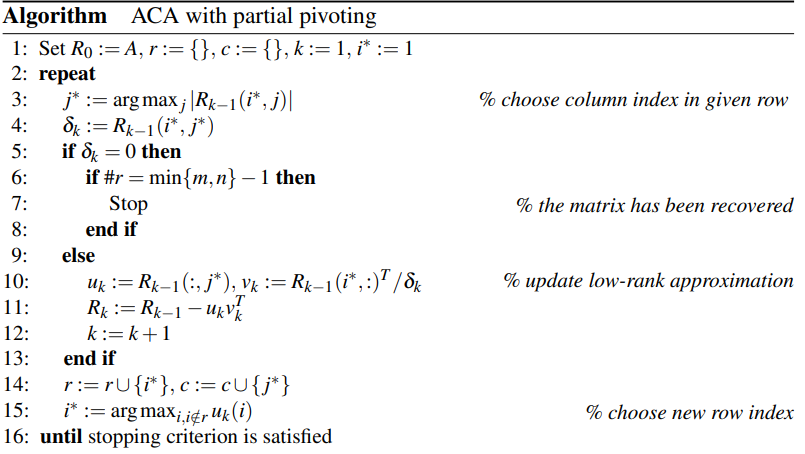

In [ ]:
def  ACA_partial_pivoting(A: np.ndarray, epsilon: float):
    '''
    Функция находит adaptive cross-approximation with partial pivoting (ACA) матрицы A

    :param A: np.ndarray размера n x m (исходная матрица)
    :epsilon: float требуемая точность построенной малоранговой аппроксимации

    :return U, V: np.ndarray размеров n x r и r x m, произведение которых аппроксимирует матрицу A
               r: int число итераций = число столбцов в матрице U = число строк в матрице V
    '''
    #Инициализация
    k = 1
    I_b = set()
    J_b = set()
    n,m = A.shape[0], A.shape[1]
    I = list(np.arange(0,n))
    R=A.copy()
    U=np.zeros((n,0))
    V=np.zeros((0,m))
    i_m = 1
    while True:
        #Нахождение максимального по модулю элемента в строке i_m матрицы R
        j_m=np.argmax(np.absolute(R), axis=1)[i_m]
        d = R[i_m, j_m]
        if d == 0:
            if len (I_b) == min(m,n)-1:
                break
        else:
            u = R[:, j_m]
            v = R[i_m, :].T/d
            R = R - np.outer(u,v)
            U = np.column_stack((U,u))
            V = np.row_stack((V,v))
            k = k+1
        J_b.add(j_m)
        I_b.add(i_m)
        I.remove(i_m)
        #Нахождение максимального по модулю элемента в u среди оставшихся индексов I
        if len(I)==0:
            break
        i_m = I[0]
        for i in I:
            if u[i] >= u[i_m]:
                i_m = i
        if np.linalg.norm(u, ord = 2)*np.linalg.norm(v, ord = 2) <= epsilon * np.linalg.norm(U@V):
            break
    return U,V,r

Тестирование ACA with full pivoting и ACA with partial pivoting на матрице Гильберта

In [ ]:
def Hilbert_matrix(n):
    H = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            H[i][j] = 1/(i+j+1)
    return H

In [ ]:
H=Hilbert_matrix(100)

In [ ]:
U,V,r=ACA_full_pivoting(H, 0.0001)
print(np.linalg.norm(H-U@V))
print(r)

2.269844369874263e-05
8


In [ ]:
U,V,r=ACA_partial_pivoting(H, epsilon=0.0001)
print(np.linalg.norm(H-U@V))
print(r)

7.331685703094589e-05
8


# maxvol
*Автор: Середа Константин*

Объем матрицы $A = |\mathrm{det}(A)|.$

Подматрица $\hat{A}_{dom} \in \mathbb C^{r \times r}$ матрицы $A \in \mathbb C^{n \times m}$ называется *доминантной*, если при замене одной строки или одного столбца на другую/другой в $\hat{A}_{dom}$ объем матрицы не увеличится.

Основная идея метода $maxvol$ состоит в нахождении доминантной подматрицы в $A$. Из существующих теорем вытекает, что лучшие результаты алгоритм $maxvol  str$ дает на лежачих или стоячих (одна размерность сильно больше другой)  матрицах малого ранга. Для матриц произвольного размера существует модификация $maxvol$ с переменными направлениями.

Некоторые замечания по использованию метода:
1. На практике мы можем упростить критерий остановки на итерационном шаге до $|c_{ij}| < 1 + δ$ с достаточно малым параметром $δ (δ ≈ 10^{-2}$ – хороший выбор). Это значительно сокращает количество итеративных шагов, но не сильно влияет на свойства искомой матрицы.
2. Ранг аппроксимации $r$, как правило, выбирается из имеющихся априорных оценок на ранг матриц, для которых решается задача: чем ближе он к рангу $A$, тем лучше приближает крестовая аппрокимация с подматрицей максимального объема.
3. Эксперименты показывают, что по два прохода (параметр $changes$) по строкам и столбцам достаточно для нахождения подматрицы, близкой по объему к доминантной.
4. Формула Шермона-Моррисона-Вудбери, реализованная в алгоритмах, позволяет сократить число вычислений при обращении матрицы, в которой на каждом шаге меняется всего одна строка/столбец, асимптотически в $r$ раз:
$$ (B+uv^\top)^{-1} = B^{-1}-\frac{B^{-1} uv^\top B^{-1}}{1+v^\top B^{-1}u}$$



**Сложность:** $O((M+N)r·iter+(M+N)r^2·IT)$,
где $iter$ – общее количество замен строк и столбцов, то есть количество итераций цикла “while” в строке 6,
$IT$ –  количество проходов по строкам и столбцам, то есть общее количество итераций цикла “for” (строка 2).


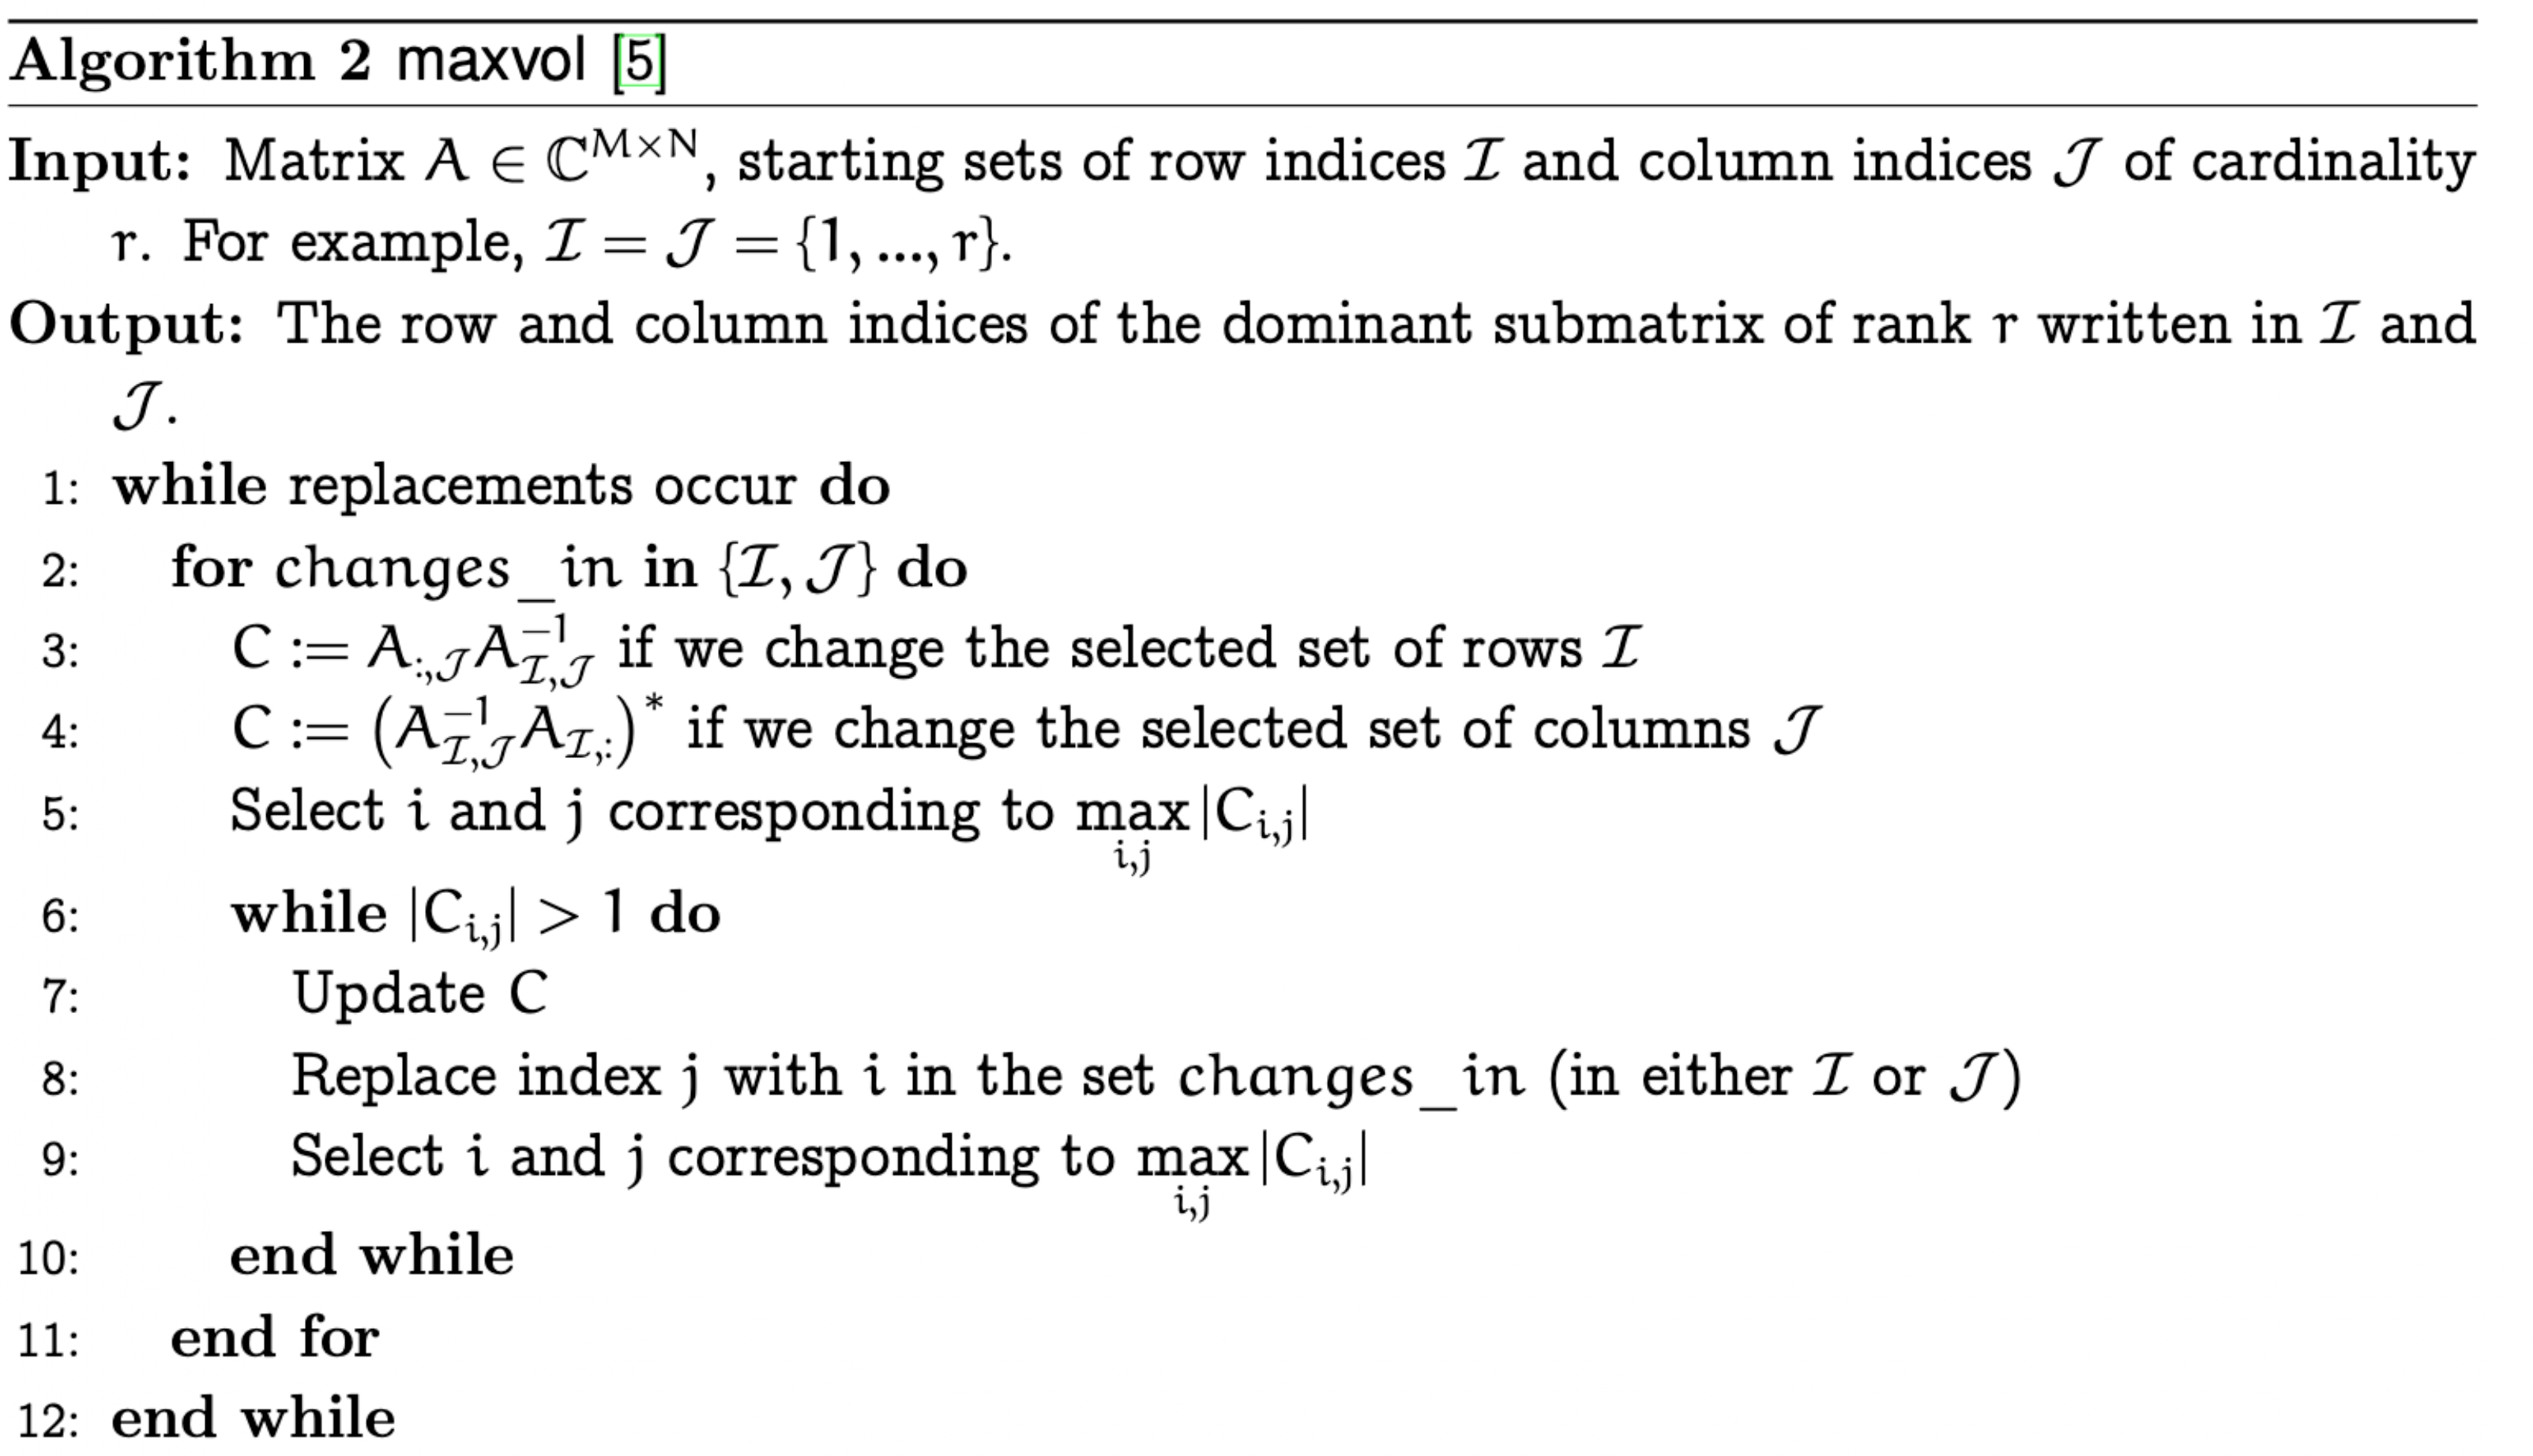

In [5]:
def maxvol_str(A: np.ndarray, I: list, delta: float=10**(-2)) -> list:
    '''
    Функция находит строки доминантной матрицы в А

    :param A: np.ndarray размера n x r -- исходная матрица
    :param I: list из строк А длины r для начальной иницилизации hatA
    :param delta: float допустимая погрешность при проверки критерия остановки

    :return I_dom: list со строками доминантой матрицы hatA_dom
    '''
    hatA = A[I]
    # Начальная инициализация матриц hatA_inv и C
    hatA_inv = np.linalg.inv(hatA)
    C = A @ hatA_inv
    while np.max(abs(C))>1+delta:
        # Поиск индексов максимального по модулю элемента C
        i, j = np.asarray(np.isclose(C, C.flat[abs(C).argmax()])).nonzero()
        i, j = i[0], j[0]
        if i==j:
            break
        # Обновление hatA_inv и C
        hatA_inv = hatA_inv - (np.outer(hatA_inv[:,j],  np.dot(A[i]-A[I[j]], hatA_inv))) * 1/(1+np.dot(A[i]-A[I[j]], hatA_inv[:,j]))
        C = A @ hatA_inv
        I[j] = i # Замена индекса
    I_dom = list(I)
    return I_dom

In [6]:
def maxvol(A: np.ndarray, r: int, changes: int=2) -> tuple:
    '''
    Функция находит близкую к доминантной матрицу в A

    :param A: np.ndarray размера n x m -- исходная матрица
    :param r: int размер крестовой аппроксимации А
    :param changes: int число обходов "строка+столбец"

    :return result: tuple (I_domt, J_domt) из двух списков индексов А, задающих доминантную матрицу
    '''
    # Начальная инициализация строк I и столбцов J искомой доминантной матрицы
    I = list(range(r))
    J = list(range(r))
    for _ in range(changes):
        I_domt = maxvol_str(A[:, J], I) # Поиск hatA_dom по строкам в подматрице A(:, J)
        J_domt = maxvol_str(A[I_domt].T, J) # Поиск hatA_dom по столбцам в подматрице A(I_domt, :)
        I = I_domt
        J = J_domt
    result = (I_domt, J_domt)
    return result

In [7]:
# Поиск подматрицы максимального объема в А
det = 0
I_best = np.arange(k)
J_best = np.arange(k)
for i in list(itertools.combinations(range(n), r=k)):
    for j in list(itertools.combinations(range(m), r=k)):
        B = A[i,:][:,j]
        det_l = np.linalg.det(B)
        if abs(det_l) > det:
            det = abs(det_l)
            I_best = i
            J_best = j

In [8]:
I_res, J_res = maxvol(A, k)
E = A - A[:,J_best] @ np.linalg.inv(A[I_best,:][:,J_best]) @ A[I_best,:]
F = A - A[:,J_res] @ np.linalg.inv(A[I_res,:][:,J_res]) @ A[I_res,:]
print('Отклонение по норме Чебышева для A_max:', np.max(abs(E)))
print('Отклонение по норме Чебышева для A_dom:', np.max(abs(F)))

Отклонение по норме Чебышева для A_max: 4.17541436097111
Отклонение по норме Чебышева для A_dom: 5.551435643019069


# maxvol-2 (rect-maxvol)
*Автор: Николаев О.В.*


Объем квадратной матрицы $A$ имеет естественный геометрический смысл как
объем параллелепипеда, натянутого на строки матрицы A, и равен
к произведению его сингулярных значений. Это определение можно прямо
обобщить на прямоугольный случай как  $\sqrt{detA^*A}$ или $\sqrt{detAA^*}$, в зависимости от
формы $A$. Предположим, что число строк матрицы $A$ не меньше
чем количество столбцов. Итак, мы используем  $\sqrt{detA^*A}$ как значение объема прямоугольной матрицы $A$:
$$
vol(A) = \sqrt{detA^*A}$$

*rect_maxvol* является естественным расширением исходного алгоритма maxvol для нахождения прямоугольной подматрицы максимального объема

Пусть матрица $A$ имеет размерность $N-на-r$ и имеет ранг $r$, $r \leq N$

Необходимо найти подматрицу максимального объема размером $K-на-r$, $K \leq N$

Максимальный объем означает, что замена колонки из найденой подматрицы на не используемую колонку из исходной матрицы не увеличивает объем

**Algorithm 1 rect_maxvol (“Greedy” maximization of the volume of submatrix)**



<div>
<img src="https://raw.githubusercontent.com/ol3gka/AI_Masrters_NLA_project_1_Matrix_Masters/main/pictures/rect_maxvol_1.jpg" width="600"/>
</div>

In [ ]:
def rect_maxvol(
    A,
    tol=1.0,
    maxK=None,
    min_add_K=None,
    minK=None,
    start_maxvol_iters=10,
    identity_submatrix=True,
    top_k_index=-1):
    """
    Реализация алгоритма rect_maxvol: нахождение прямоугольной подматрицы с максимальным объемом

    Args:
      A (numpy.ndarray(ndim=2)): Действительная или комплексная матрица формы (N, r), N >= r.
      tol (float, optional): Верхняя граница евклидовой нормы коэффициентов расширения строк A по строкам наилучшей (макс по объему) подматрицы. Defaults to 1.0.
      maxK (integer, optional): Максимальное количество строк в наилучшей подматрице. Defaults to N if not set explicitly.
      minK (integer, optional): Минимальное количество строк в наилучшей подматрице. Defaults to r if not set explicitly.
      min_add_K (integer, optional): Минимальное количество строк, добавляемых в квадратную подматрицу. Полученная наилучшая матрица будет содержать минимум r+min_add_K строк. Ignored if not set explicitly.
      start_maxvol_iters (integer, optional): Сколько итераций квадратного of square maxvol (optimization of 1-volume) необходимо выполнить перед фактической прямоугольной максимизацией 2-volume maximization. Defaults to 10.
      identity_submatrix (boolean, optional): maxvol. Если identity_submatrix имеет значение True, возвращаемая матрица коэффициентов будет иметь подматрицу, соответствующую хорошим строкам, установленную на единицу. Defaults to True.
      top_k_index (integer, optional): Сводные строки для наилучшей подматрицы будут находиться в диапазоне от 0 до (top_k_index-1). This restriction is ignored, if top_k_index is -1. Defaults to -1.

    Returns:
      piv (numpy.ndarray(ndim=1, dtype=numpy.int32)): Строки матрицы A,соответствующие подматрице, хорошие с точки зрения 2-volume. Shape is (K, ).
      C (numpy.ndarray(ndim=2)): Матрица коэффициентов разложения всех строк матрицы A на хорошие строки piv. Shape is (N, K).
    """
    # tol2 - квадрат параметра tol
    tol2 = tol**2
    # N - число строк, r - число колонок матрицы A
    N, r = A.shape
    # работа над параметрами
    if N <= r:
        return np.arange(N, dtype=np.int32), np.eye(N, dtype=A.dtype)
    if maxK is None or maxK > N:
        maxK = N
    if maxK < r:
        maxK = r
    if minK is None or minK < r:
        minK = r
    if minK > N:
        minK = N
    if min_add_K is not None:
        minK = max(minK, r + min_add_K)
    if minK > maxK:
        minK = maxK
        #raise ValueError('minK value cannot be greater than maxK value')
    if top_k_index == -1 or top_k_index > N:
        top_k_index = N
    if top_k_index < r:
        top_k_index = r
    # выбор изначальной подматрицы и коэффициентов согласно maxvol алгоритму
    index = np.zeros(N, dtype=np.int32)
    chosen = np.ones(top_k_index)
    tmp_index, C = square_maxvol(A, 1.05, start_maxvol_iters, top_k_index)
    index[:r] = tmp_index
    chosen[tmp_index] = 0
    C = np.asfortranarray(C)
    # вычислим квадратные 2-нормы каждой строки в матрице коэффиценттов матриы C
    row_norm_sqr = np.array([chosen[i]*np.linalg.norm(C[i], 2)**2 for
        i in range(top_k_index)])
    # находим максимальное число в row_norm_sqr
    i = np.argmax(row_norm_sqr)
    K = r
    # выберете cgeru или zgeru для комплексных чисел и dger или sger для float
    try:
        ger = get_blas_funcs('geru', [C])
    except:
        ger = get_blas_funcs('ger', [C])
    # изменяем (увеличиваем) maxvol подматрицу с каждой итерацией
    while (row_norm_sqr[i] > tol2 and K < maxK) or K < minK:
        # прибавляем i к индексу и пересчитываем С и квадратные нормы для каждой
        # строки с помощью SVM-формулы
        index[K] = i
        chosen[i] = 0
        c = C[i].copy()
        v = C.dot(c.conj())
        l = 1.0/(1+v[i])
        ger(-l,v,c,a=C,overwrite_a=1)
        C = np.hstack([C, l*v.reshape(-1,1)])
        row_norm_sqr -= (l*v[:top_k_index]*v[:top_k_index].conj()).real
        row_norm_sqr *= chosen
        # найти максимальное значение в row_norm_sqr
        i = row_norm_sqr.argmax()
        K += 1
    # если identity_submatrix is True, установите подматрицу соответсвующую
    # maxvol строкам, раной identity матрице
    if identity_submatrix:
        C[index[:K]] = np.eye(K, dtype=C.dtype)
    return index[:K].copy(), C


def square_maxvol(A, tol=1.05, max_iters=100, top_k_index=-1):
    """
    Реализация Maxvol алгоритма для использования
    """
    if tol < 1:
        tol = 1.0
    N, r = A.shape
    if N <= r:
        return np.arange(N, dtype=np.int32), np.eye(N, dtype=A.dtype)
    if top_k_index == -1 or top_k_index > N:
        top_k_index = N
    if top_k_index < r:
        top_k_index = r
    B = np.copy(A[:top_k_index], order='F')
    C = np.copy(A.T, order='F')
    H, ipiv, info = get_lapack_funcs('getrf', [B])(B, overwrite_a=1)
    index = np.arange(N, dtype=np.int32)
    for i in range(r):
        tmp = index[i]
        index[i] = index[ipiv[i]]
        index[ipiv[i]] = tmp
    B = H[:r]
    trtrs = get_lapack_funcs('trtrs', [B])
    trtrs(B, C, trans=1, lower=0, unitdiag=0, overwrite_b=1)
    trtrs(B, C, trans=1, lower=1, unitdiag=1, overwrite_b=1)
    i, j = divmod(abs(C[:,:top_k_index]).argmax(), top_k_index)
    try:
        ger = get_blas_funcs('geru', [C])
    except:
        ger = get_blas_funcs('ger', [C])
    iters = 0
    while abs(C[i,j]) > tol and iters < max_iters:
        index[i] = j
        tmp_row = C[i].copy()
        tmp_column = C[:,j].copy()
        tmp_column[i] -= 1.
        alpha = -1./C[i,j]
        ger(alpha, tmp_column, tmp_row, a=C, overwrite_a=1)
        iters += 1
        i, j = divmod(abs(C[:,:top_k_index]).argmax(), top_k_index)
    return index[:r].copy(), C.T


In [ ]:
np.random.seed(100)
a = np.random.rand(1000, 30, 2).view(dtype=np.complex128)[:,:,0]
piv, C = rect_maxvol(a, 1.0)
np.allclose(a, C.dot(a[piv]))

True

In [ ]:
print(f'Максималльное значение Эвклидовой нормы строк в матрице C: {max([np.linalg.norm(C[i], 2) for i in range(1000)]):.5f}')

maximum euclidian norm of row in matrix C: 1.00000


In [ ]:
piv, C = rect_maxvol(a, 1.5)
np.allclose(a, C.dot(a[piv]))

True

In [ ]:
print(f'Максималльное значение Эвклидовой нормы строк в матрице C: {max([np.linalg.norm(C[i], 2) for i in range(1000)]):.5f}')

maximum euclidian norm of row in matrix C: 1.49193


In [ ]:
piv, C = rect_maxvol(a, 2.0)
np.allclose(a, C.dot(a[piv]))

True

In [ ]:
print(f'Максималльное значение Эвклидовой нормы строк в матрице C: {max([np.linalg.norm(C[i], 2) for i in range(1000)]):.5f}')

maximum euclidian norm of row in matrix C: 1.91954


In [ ]:
m = 50
time_dict = {}
for n in tqdm(np.logspace(2, 5, num=200, dtype=int)):
  # print(n)
  a = np.random.rand(n, m, 2).view(dtype=np.complex128)[:,:,0]
  start_time = time.time()
  piv, C = rect_maxvol(a, 1.0)
  end_time = time.time()
  time_dict[n]=(end_time - start_time) # секунды

100%|██████████| 200/200 [04:20<00:00,  1.30s/it]


In [ ]:
time_experiments = pd.DataFrame(data=time_dict.values(), columns=["time, s"], index=time_dict.keys())

In [ ]:
def fit_func(x, a, b):
  return a + b*x**1

popt, pcov = curve_fit(fit_func, list(time_dict.keys()), list(time_dict.values()))

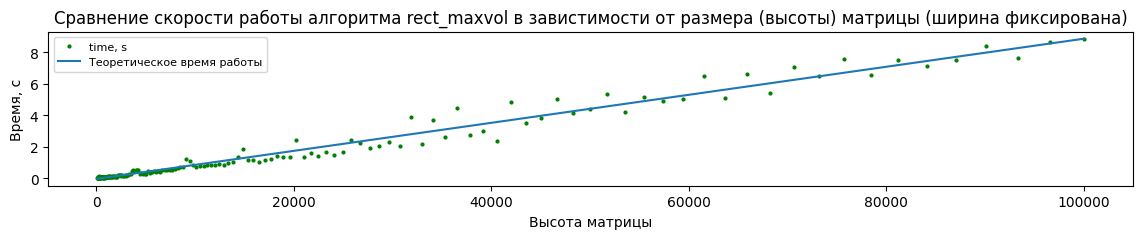

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
time_experiments.plot(marker='o', markersize=2, linestyle = 'None', ax=ax, c='g')

ax.plot(np.array(list(time_dict.keys())), fit_func(np.array(list(time_dict.keys())), *popt), label="Теоретическое время работы")

plt.legend(loc ="upper left", fontsize=8)
plt.title(f'Сравнение скорости работы алгоритма rect_maxvol в завистимости от размера (высоты) матрицы (ширина фиксирована)')
ax.set_xlabel(f"Высота матрицы")
ax.set_ylabel(f"Время, с")
plt.show()

In [ ]:
np.linalg.cond(pcov)  # small is good


2.94206214176847e+28

# Maxvol

In [ ]:
def matrix_volume(A: np.array):
    _, S, _ = np.linalg.svd(A, full_matrices=True)
    return np.prod(S[:min(A.shape)])
def basis(size,index):
    a = np.zeros(size)
    a[index] = 1
    return a
def swap(C,A,B,order):
    for a,b in zip(A,B):
        C[[a,b]] = C[[b,a]]
        order[a], order[b] = order[b], order[a]

def swap_columns(C,A,B,order):
    for a,b in zip(A,B):
        C[:,[a,b]] = C[:,[b,a]]
        order[a], order[b] = order[b], order[a]

In [ ]:
def householder(x: np.ndarray):
    alpha = x[0]
    s = np.power(np.linalg.norm(x[1:]), 2)
    v = x.copy()

    if s == 0:
        tau = 0
    else:
        t = np.sqrt(alpha**2 + s)
        v[0] = alpha - t if alpha <= 0 else -s / (alpha + t)

        tau = 2 * v[0]**2 / (s + v[0]**2)
        v /= v[0]

    return v, tau

def givens(a,b):
    c,s = 1, 0
    if b!= 0:
        if abs(b) > abs(a):
            t = -a/b
            s = 1/(1+t**2)**0.5
            c = s*t
        else:
            t = -b/a
            c = 1/(1+t**2)**0.5
            s = c*t
    return c,s

In [ ]:
def maxvol_0 (A: np.array, I:np.array, J:np.array):

    m, n = A.shape
    C = A[:,J] @ np.linalg.inv(A[np.ix_(I,J)])
    current_order = np.arange(m)
    swap(C,I,np.arange(r),current_order)
    (i, j) = np.unravel_index(np.abs(C).argmax(), C.shape)
    changed = True
    old_changed = True
    while changed:
        changed = False
        #two types of cycle for I and g
        for type_flg in (False,True): #False for I iter, True for J iter

            while np.abs(C[i,j]) > 1:
                if i == j:
                    break
                C = C - C[:,[j]] @ (C[[i],:] - basis(C.shape[1],j))/C[i,j]
                swap(C,[i],[j],current_order)
                changed = True
                old_changed = True
            if (not changed) and type_flg:
                changed = False
                break
            if (not old_changed) and (not type_flg):
                changed = False
                break
            if type_flg:
                J = current_order[:r]
                old_changed = False
                C = A[:,J] @ np.linalg.inv(A[np.ix_(I,J)])
                current_order = np.arange(m)
                swap(C,I,np.arange(r),current_order)
            else:
                I = current_order[:r]
                C = A[I,:].T @ np.linalg.inv(A[np.ix_(I,J)]).T
                current_order = np.arange(n)
                swap(C,J,np.arange(r),current_order)

            (i, j) = np.unravel_index(np.abs(C).argmax(), C.shape)
    return I, J

In [ ]:
def hmaxvol2 (A: np.array, I:np.array, n:int):

    m = A.shape[0]
    C = A @ np.hstack((np.linalg.inv(A[I,:]),np.zeros((r,n-r))))
    current_order = np.arange(m)
    swap(C,I,np.arange(r),current_order)
    C = C[r:,:]
    l = np.zeros(m-r)
    for i in range(m-r):
        l[i] = np.linalg.norm(C[i,:])**2

    for new_size in range(n-r):
        i = l.argmax()
        current_order[new_size+r], current_order[i+r] = current_order[i+r], current_order[new_size+r]
        ll = 1 + l[i]
        l[i] = l[new_size]
        l[new_size] = 0
        CI = C[i,:]
        v, t = householder(CI)
        v = v[:,None]
        C[i,:] = C[new_size,:]
        C[new_size,:] = 0
        #print(v,v.conj().T)
        C = C - t * C @ v @ v.conj().T
        for j in range(new_size,m-r):
            #print(l[j])
            l[j] -= (1 - 1/ll)*C[j,0]**2
        C[:,0] /= ll**0.5
    return current_order[:n]


In [ ]:
def maxvol22 (A: np.array, I:np.array, J:np.array, n:int, m:int):
    I,J = maxvol_0(A,I,J)
    C = A[:,J]
    R = A[I]
    I = hmaxvol2(C,I,n)
    J = hmaxvol2(R.T,J,m)
    return I,J

In [ ]:
m = 25
r = 20
n = 25
M = 2000
N = 2000
A = np.random.rand(M, N)
I = np.random.choice(list(range(M)),size=r,replace=False)
J = np.random.choice(list(range(N)),size=r,replace=False)
print(matrix_volume(A[np.ix_(I,J)]))
I,J = maxvol22(A,I,J,n,m)
print(matrix_volume(A[np.ix_(I,J)]))

0.01354421512048101
3386.7458600440127


# Эксперименты

In [14]:
# Измерение времени работы приближения матрицы A и Чебышевской нормы приращения
def svd_meas(A: np.ndarray) -> tuple:
    start_time = time.time()
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    end_time = time.time()
    t = end_time - start_time
    norm = np.max(abs(A-np.dot(U * S, Vh)))/np.max(abs(A))
    return (t, norm)

def qr_meas(A: np.ndarray) -> tuple:
    start_time = time.time()
    Q, R = np.linalg.qr(A)
    end_time = time.time()
    t = end_time - start_time
    norm = np.max(abs(A-np.matmul(Q, R)))/np.max(abs(A))
    return (t, norm)

def maxvol_meas(A: np.ndarray, r: int) -> tuple:
    start_time = time.time()
    I_res, J_res = maxvol(A, r)
    end_time = time.time()
    Delta = A - A[:,J_res] @ np.linalg.inv(A[I_res,:][:,J_res]) @ A[I_res,:]
    t = end_time - start_time
    norm = np.max(abs(Delta))/np.max(abs(A))
    return (t, norm)

In [15]:
# Генератор случайных матриц размера n x m и ранга rk
def generator(n: int, m: int, rk: int) -> np.ndarray:
    k = min(n,m)
    sigma = np.sort(np.hstack((np.random.rand(rk), np.zeros(k-rk))))[::-1]
    if n<=m:
        S = np.hstack((np.diag(sigma), np.zeros((n,m-n))))
    else:
        S = np.vstack((np.diag(sigma), np.zeros((n-m,m))))
    B = np.random.rand(n,n)
    C = np.random.rand(m,m)
    Q_1 = np.linalg.qr(B)[0]
    Q_2 = np.linalg.qr(C)[0].T
    A = Q_1 @ S @ Q_2
    return A

In [20]:
# Генератор случайных матриц размера n x m и ранга rk с экспоненциально убывающими сингулярными числами
def generator(n, m, rk):
    k = min(n,m)
    alpha = np.linspace(0.01, 6, rk)
    sigma = np.array([1])
    for i in range(rk-1):
        a = alpha[i]
        sigma = np.append(sigma, abs(np.exp(-1/(a**2))-1))
    sigma = np.sort(np.hstack((sigma, np.zeros(k-rk))))[::-1]
    #sigma = np.sort(np.hstack((np.random.rand(rk), np.zeros(k-rk))))[::-1]
    if n<=m:
        S = np.hstack((np.diag(sigma), np.zeros((n,m-n))))
    else:
        S = np.vstack((np.diag(sigma), np.zeros((n-m,m))))
    B = np.random.rand(n,n)
    C = np.random.rand(m,m)
    Q_1 = np.linalg.qr(B)[0]
    Q_2 = np.linalg.qr(C)[0].T
    A = Q_1 @ S @ Q_2
    return A

In [21]:
r = 50
time_dict_svd, norm_dict_svd = {}, {}
time_dict_qr, norm_dict_qr = {}, {}
time_dict_maxvol, norm_dict_maxvol = {}, {}
for n in tqdm(np.logspace(2, 3, num=20)):
    A = generator(int(n), int(n), r)
    time_dict_svd[n], norm_dict_svd[n]= svd_meas(A)
    time_dict_qr[n], norm_dict_qr[n] = qr_meas(A)
    time_dict_maxvol[n], norm_dict_maxvol[n] = maxvol_meas(A, r)

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


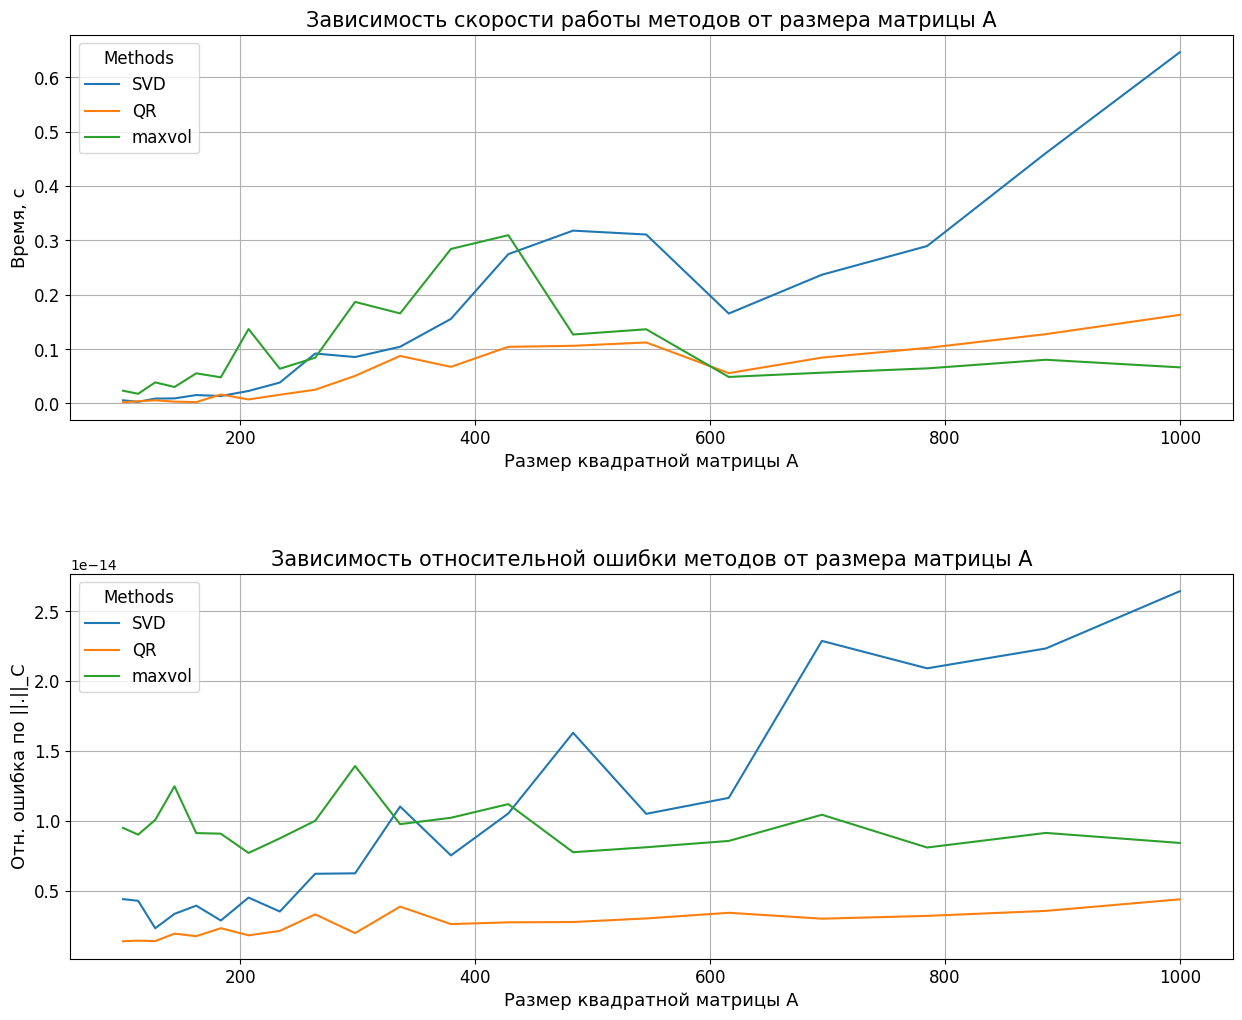

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

ax[0].plot(time_dict_svd.keys(), time_dict_svd.values(), label='SVD')
ax[0].plot(time_dict_qr.keys(), time_dict_qr.values(), label='QR')
ax[0].plot(time_dict_maxvol.keys(), time_dict_maxvol.values(), label='maxvol')
ax[0].set_title('Зависимость скорости работы методов от размера матрицы A', fontsize=15)
ax[0].set_ylabel('Время, с', fontsize=13)
ax[0].set_xlabel('Размер квадратной матрицы А', fontsize=13)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].grid(True)
ax[0].legend(title='Methods', fontsize=12, title_fontsize=12)

ax[1].plot(norm_dict_svd.keys(), norm_dict_svd.values(), label='SVD')
ax[1].plot(norm_dict_qr.keys(), norm_dict_qr.values(), label='QR')
ax[1].plot(norm_dict_maxvol.keys(), norm_dict_maxvol.values(), label='maxvol')
ax[1].set_title('Зависимость относительной ошибки методов от размера матрицы A', fontsize=15)
ax[1].set_ylabel('Отн. ошибка по ||.||_C', fontsize=13)
ax[1].set_xlabel('Размер квадратной матрицы А', fontsize=13)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].grid(True)
ax[1].legend(title='Methods', fontsize=12, title_fontsize=12)

fig.set_size_inches(15, 12)
plt.subplots_adjust(hspace=0.4)
plt.show()